<a href="https://colab.research.google.com/github/AkankshaK-AI/S6-Assignment/blob/main/EVA7S6_L1_%26_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Adding StepLR to further improve model performance

# Import Libraries

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations
Image augmentation has been added


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0,7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                      #  # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics



In [7]:
# We'd need to convert it into Numpy! Above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# # Let's visualize some of the images
# %matplotlib inline
# import matplotlib.pyplot as plt

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [8]:
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Getting mean and std values for the transforms



In [9]:

# simple_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.ToTensor(),
#                                       #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
#                                        # Note the difference between (0.1307) and (0.1307,)
#                                        ])
# exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
# exp_data = exp.train_data
# exp_data = exp.transform(exp_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', exp.train_data.size())
# print(' - min:', torch.min(exp_data))
# print(' - max:', torch.max(exp_data))
# print(' - mean:', torch.mean(exp_data))
# print(' - std:', torch.std(exp_data))
# print(' - var:', torch.var(exp_data))

# The model
Increasing the number of parameters and correcting the Max pooling location

In [10]:
# dropout_value=0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=28*28,output_size =26*26, RF=3*3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=26*26,output_size =24*24, RF=5*5

        # Transition block 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=24*24,output_size =24*24, RF=5*5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12*12, RF=6*6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=12*12, output_size = 10*10, RF=10*10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=10*10, output_size = 8*8, RF=14*14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=8*8, output_size = 6*6, RF=18*18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=6*6, output_size = 6*6, RF=22*22

        # OUTPUT BLOCK  
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1*1
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
        ) # adding parameters after GAP layer



        # self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 20, 24, 24]           1,800
       BatchNorm2d-5           [-1, 20, 24, 24]              40
              ReLU-6           [-1, 20, 24, 24]               0
            Conv2d-7           [-1, 10, 24, 24]             200
         MaxPool2d-8           [-1, 10, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           1,440
      BatchNorm2d-10           [-1, 16, 10, 10]              32
             ReLU-11           [-1, 16, 10, 10]               0
           Conv2d-12             [-1, 16, 8, 8]           2,304
      BatchNorm2d-13             [-1, 16, 8, 8]              32
             ReLU-14             [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing



Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = [] # train accuracy
test_acc = [] #test accuracy
misclassified=[]

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # L1 loss
    l1=0
    factor=0.001
    for parameter in model.parameters():
      l1=l1+torch.sum(abs(parameter))

    # Sum of losses(cross entropy and L1)
    loss=loss+(factor*l1)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, misclassified):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for i in range(len(pred)):
              if pred[i]!= target[i]:
                misclassified.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()



    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [14]:

%matplotlib inline
import matplotlib.pyplot as plt

def plot_misclassified(misclassified):
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassified[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        
        sub.set_title("Pred={}, Act={}".format(str(misclassified[i][1].data.cpu().numpy()),str(misclassified[i][2].data.cpu().numpy())))
        
  plt.tight_layout()

  plt.show()

# Let's Train and test our model

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.49021169543266296 Batch_id=468 Accuracy=85.43: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]



Test set: Average loss: 0.1388, Accuracy: 9644/10000 (96.44%)

EPOCH: 1


Loss=0.4354533553123474 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]



Test set: Average loss: 0.0683, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Loss=0.3904377222061157 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]



Test set: Average loss: 0.0723, Accuracy: 9793/10000 (97.93%)

EPOCH: 3


Loss=0.3429771363735199 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:23<00:00, 20.16it/s]



Test set: Average loss: 0.0612, Accuracy: 9834/10000 (98.34%)

EPOCH: 4


Loss=0.37132060527801514 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]



Test set: Average loss: 0.0878, Accuracy: 9729/10000 (97.29%)

EPOCH: 5


Loss=0.2984224557876587 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s]



Test set: Average loss: 0.0628, Accuracy: 9822/10000 (98.22%)

EPOCH: 6


Loss=0.41168925166130066 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:23<00:00, 19.86it/s]



Test set: Average loss: 0.0628, Accuracy: 9800/10000 (98.00%)

EPOCH: 7


Loss=0.3014906942844391 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:23<00:00, 19.84it/s]



Test set: Average loss: 0.1066, Accuracy: 9685/10000 (96.85%)

EPOCH: 8


Loss=0.3052467107772827 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s]



Test set: Average loss: 0.0978, Accuracy: 9707/10000 (97.07%)

EPOCH: 9


Loss=0.33295631408691406 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]



Test set: Average loss: 0.0835, Accuracy: 9747/10000 (97.47%)

EPOCH: 10


Loss=0.2752962112426758 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:23<00:00, 19.85it/s]



Test set: Average loss: 0.0552, Accuracy: 9840/10000 (98.40%)

EPOCH: 11


Loss=0.32359400391578674 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:23<00:00, 20.01it/s]



Test set: Average loss: 0.0706, Accuracy: 9799/10000 (97.99%)

EPOCH: 12


Loss=0.2724366784095764 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:23<00:00, 20.38it/s]



Test set: Average loss: 0.0806, Accuracy: 9733/10000 (97.33%)

EPOCH: 13


Loss=0.3093932569026947 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:23<00:00, 19.95it/s]



Test set: Average loss: 0.0655, Accuracy: 9818/10000 (98.18%)

EPOCH: 14


Loss=0.28874555230140686 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:23<00:00, 20.06it/s]



Test set: Average loss: 0.0701, Accuracy: 9778/10000 (97.78%)

EPOCH: 15


Loss=0.35019028186798096 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:23<00:00, 19.94it/s]



Test set: Average loss: 0.1601, Accuracy: 9475/10000 (94.75%)

EPOCH: 16


Loss=0.22456862032413483 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:23<00:00, 20.20it/s]



Test set: Average loss: 0.1109, Accuracy: 9644/10000 (96.44%)

EPOCH: 17


Loss=0.2572656571865082 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]



Test set: Average loss: 0.0698, Accuracy: 9778/10000 (97.78%)

EPOCH: 18


Loss=0.2304530292749405 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:23<00:00, 20.11it/s]



Test set: Average loss: 0.1139, Accuracy: 9621/10000 (96.21%)

EPOCH: 19


Loss=0.1964906007051468 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]



Test set: Average loss: 0.0495, Accuracy: 9858/10000 (98.58%)



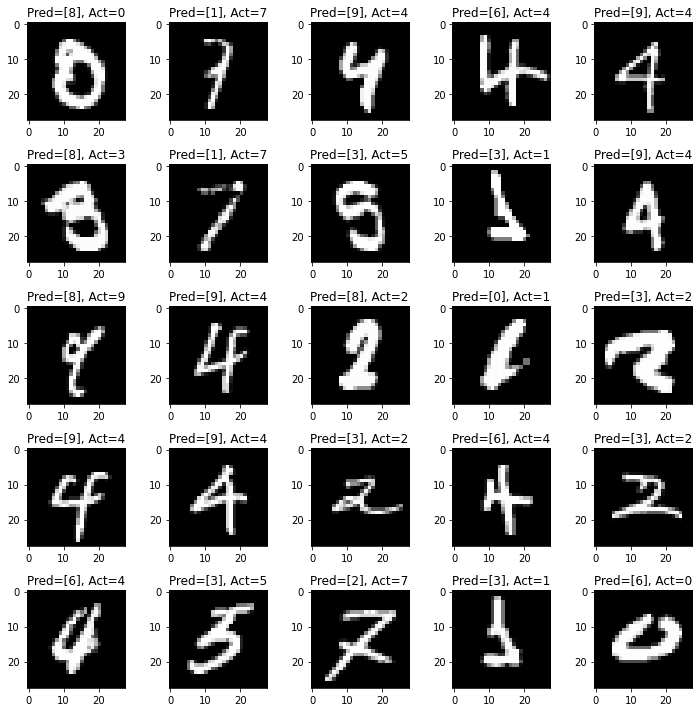

In [15]:

from torch.optim.lr_scheduler import StepLR  # We have added Step LR here. We will be dropping the LR after every 6 epochs

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) #We will be dropping the LR by 0.1 after every 6 epochs

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader, misclassified)

plot_misclassified(misclassified)

Text(0.5, 1.0, 'Test Accuracy')

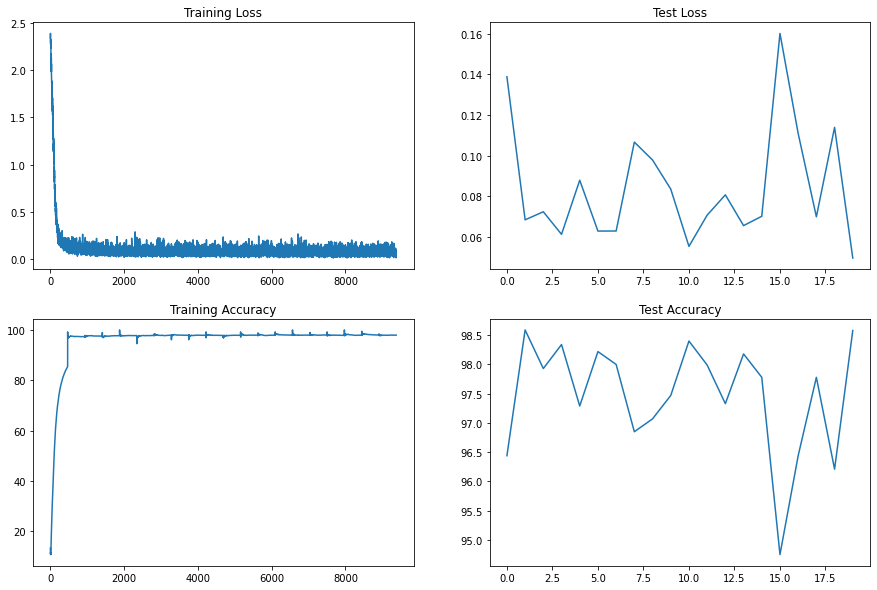

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")